test 12.5 8.5 5.5
test 12.5 8.5 5.5
test 12.5 8.5 5.5
test 12.5 8.5 5.5
test 8.7 12 3.7
test 8.7 12 3.7
test 8.7 12 3.7
test 8.7 12 3.7
test 8.7 12 3.7
test 8.7 12 3.7
test 13.45 9.75 3.45
test 13.45 9.75 3.45
test 13.45 9.75 3.45
test 13.45 9.75 3.45
test 13.45 9.75 3.45


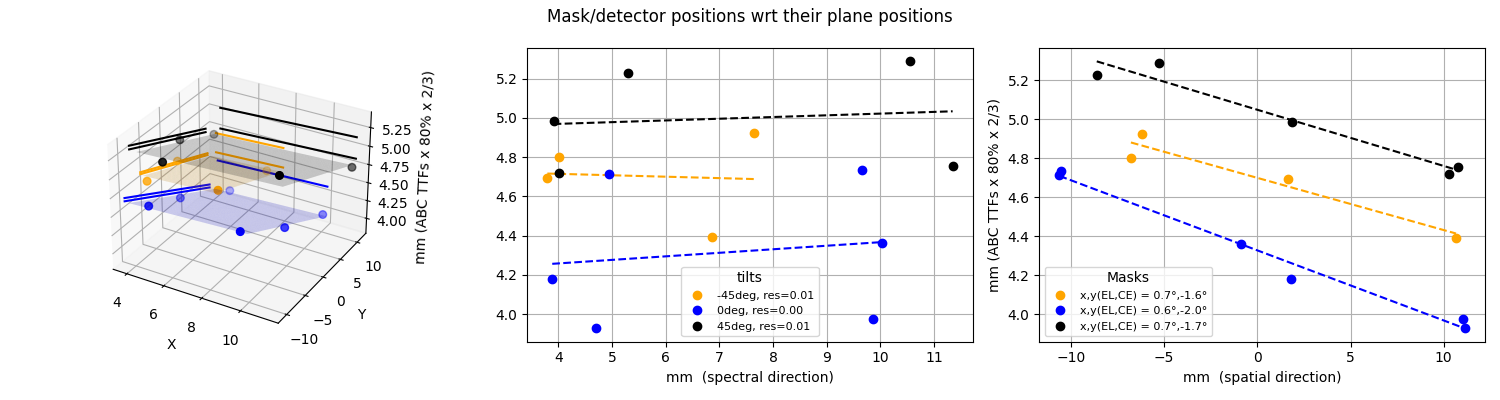

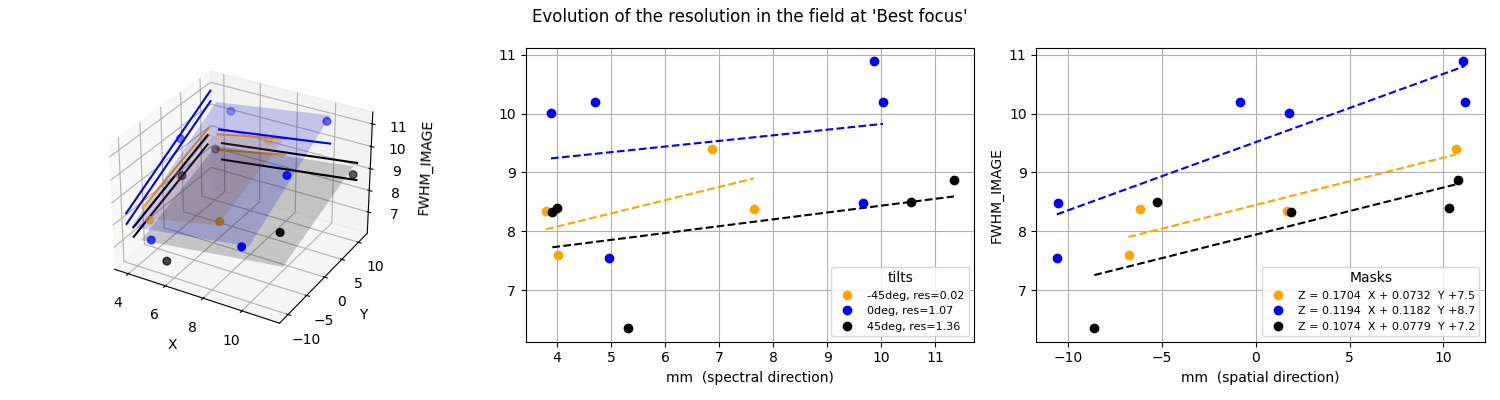

In [2]:
%matplotlib widget
import sys
# sys.path.insert(0,'/content/pyds9plugin')
from astropy.table import Table
import matplotlib.pyplot as plt
import glob
import numpy as np
# from google.colab import drive
# from google.colab import files

from pyds9plugin.DS9Utils import PlotFit1D

def fit_quadratic_curve(x, y, z, sigma_z=None, order=2, Plot=True, n=100, ax=None, c="r", title=None,legend=""):
    """Linear or quadratic fit of data
    """
    import matplotlib
    import matplotlib.cm as cmx
    from scipy import linalg

    cm = plt.get_cmap("twilight_shifted")
    cNorm = matplotlib.colors.Normalize(vmin=1, vmax=4)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

    if sigma_z is None:
        index = np.isfinite(z)
        #        data = np.array(zip(x[index],y[index],z[index]))
        data = np.array([x[index], y[index], z[index]]).T
    else:
        index = (np.isfinite(z)) & (np.isfinite(sigma_z))
        data = np.array(zip(x[index], y[index], z[index] / sigma_z[index]))
    # regular grid covering the domain of the data
    X, Y = np.meshgrid(np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n))
    # X, Y = np.meshgrid(np.linspace(0, x.max(), n), np.linspace(0, y.max(), n))
    XX = X.flatten()
    YY = Y.flatten()

    order = order  # 1: linear, 2: quadratic
    if order == 1:
        # best-fit linear plane
        if sigma_z is None:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])]
        else:
            A = np.c_[data[:, 0], data[:, 1], np.ones(data.shape[0])] / sigma_z[:, np.newaxis]

        C, _, _, _ = linalg.lstsq(A, data[:, 2])  # coefficients
        # evaluate it on grid
        Z = C[0] * X + C[1] * Y + C[2]
        z_plane = C[0] * x + C[1] * y + C[2]
        res = np.sum(np.square(z - z_plane))
        # or expressed using matrix/vector product
        # Z = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(X.shape)
        l ="%s: Z = %0.4f * X + %0.4f * Y +%0.1f\nangles x,y(EL,CE) = %0.1fdeg,%0.1fdeg"%(legend,C[0], C[1], C[2],180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi)
    elif order == 2:
        if sigma_z is None:
            # best-fit quadratic curve
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), data[:, :2] ** 2]
        else:
            # best-fit quadratic curve
            A = np.c_[np.ones(data.shape[0]), data[:, :2], np.prod(data[:, :2], axis=1), (data[:, :2] ** 2)] / sigma_z[:, np.newaxis]
        C, _, _, _ = linalg.lstsq(A, data[:, 2])
        # evaluate it on a grid
        Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX * YY, XX ** 2, YY ** 2], C).reshape(X.shape)
        z_plane = np.dot(np.c_[np.ones(x.shape), x, y, x * y, y ** 2, y ** 2], C).reshape(X.shape)
        res = np.sum(np.square(z - z_plane))
        l = C
    if Plot:
        if ax is None:
            fig = plt.figure()#figsize=(15, 10))  # (10,8)
            # ax = fig.gca(projection="3d")
            ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2,color = c)
        # ax.contour3D(X, Y, Z, 55, cmap=c)#cmap="twilight_shifted")
        # ax.scatter(data[:, 0], data[:, 1], z[index], s=20, c=scalarMap.to_rgba(z[index]))  # cmap='twilight_shifted',vmin=1,vmax=4)
        
        ax.scatter(data[:, 0], data[:, 1], z[index], s=30, color=c,label=l)  # cmap='twilight_shifted',vmin=1,vmax=4)
        ax.contour(X, Y, Z, zdir='x', colors=[c,c],levels=1, offset=np.min(ax.get_xlim()))#[X.min(),X.max()]) offset=-4, 
        ax.contour(X, Y, Z, zdir='y',  colors=[c,c],levels=1, offset=   np.max(ax.get_ylim()))#[Y.min(),Y.max()])offset=   10,

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        # ax.legend(fontsize=8)
        ax.set_zlabel("Z")
        # scalarMap.set_array(z[index])
        try:
            fig.colorbar(scalarMap)#, fraction=0.016, pad=-0.2
        except UnboundLocalError:
            pass
        ax.axis("tight")
        if title is not None:
            ax.set_title(title)
    else:
        ax = 1
    return X, Y, Z, ax, C, res
#MGS raised 400mu
#detector lowered by 230 mu

def plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/*/",  f_detector = 0.79*2/3, f_guider = 1.45*2/3,n=1, z_direction=None,title=None,ABCs=None,lname = lambda a : a.split("/")[-2].split("_")[-1]):
    c="k"    
    cat = Table( names=("name", "cx", "cy", "c0","tx","ty"),dtype=[str,float,float,float,float,float])
    fig = plt.figure(figsize=(15,4))#,sharey=True, subplot_kw={'projection': "3d"})
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax0 = fig.add_subplot(1, 3, 2)
    ax1 = fig.add_subplot(1, 3, 3)
    # fig = plt.figure(figsize=(5,15))#,sharey=True, subplot_kw={'projection': "3d"})
    # ax = fig.add_subplot(3, 1, 1, projection='3d')
    # ax0 = fig.add_subplot(3, 1, 2)
    # ax1 = fig.add_subplot(3, 1, 3)
    folders = glob.glob(path)[:]
    folders.sort()
    # print("folders: ", folders)
    for j, (folder,c) in enumerate(zip(folders,["orange","b","k","g","r","grey","brown","pink"]*10)):
        x,y,z=[],[],[]
        # files = glob.glob(folder + "/**/**/*_cat.fits")
        files = glob.glob(folder + "/*_cat*.fits")
        if len(files)>2:
            for jj, f in enumerate(files):
                a = Table.read(f)
                # print(f)
                try:
                    i =float(a["Center"][0])*n
                except KeyError:
                    i =float(a["Center "][0])*n
                try:
                    x.append(float(a["X_IMAGE_PSF"][0]))#*0.013)
                    y.append(float(a["Y_IMAGE_PSF"][0]))#*0.013)
                except KeyError:
                    x.append(float(a["x_real_center"][5]))#*0.013)
                    y.append(float(a["y_real_center"][5]))#*0.013)

                type = "guider" if "LINAENC" in a.colnames else "detector"
                ls = ":" if "LINAENC" in a.colnames else "--"
                if z_direction is None:
                    if "LINAENC" in a.colnames:
                        Amin,Bmin,Cmin = float(a["LINAENC"][0]), float(a["LINBENC"][0]), float(a["LINCENC"][0])
                        Amax,Bmax,Cmax = float(a["LINAENC"][-1]), float(a["LINBENC"][-1]), float(a["LINCENC"][-1])
                        AS,BS,CS = np.linspace(Amin,Amax,11*n), np.linspace(Bmin,Bmax,11*n), np.linspace(Cmin,Cmax,11*n)
                        zi = f_guider * (float(AS[int(i)])+float(BS[int(i)])+float(CS[int(i)]))/ 3
                        # ls=":"
                    else:
                        # ls="--"
                        A,B,C = ABCs[j]
                        # if ("14_24_cat.fits" in os.path.basename(f)) |("27_37_cat.fits" in os.path.basename(f)) |("39_49_cat" in os.path.basename(f)):
                        #      A,B,C = 11.7, 16, 3
                        # if jj==0:
                        print(lname(f) ,  A,B,C )

                        # AS,BS,CS = np.linspace(A-5*0.25,A+5*0.25,11), np.linspace(B-5*0.25,B+5*0.25,11), np.linspace(C-5*0.25,C+5*0.25,11)
                        AS,BS,CS = np.linspace(A+5*0.25,A-5*0.25,11*n), np.linspace(B+5*0.25,B-5*0.25,11*n), np.linspace(C+5*0.25,C-5*0.25,11*n)
                        # zis = np.linspace(,,11)
                        # i = np.argmin(a["FWHM_IMAGE"])
                        zi = f_detector *(AS[int(i)]+BS[int(i)]+CS[int(i)])/ 3
                        # type="detector"
                        # zi = np.min(a["FWHM_IMAGE"])
                        # x.append(a["x_real_center"][0])
                        # y.append(a["y_real_center"][0])
                else:
                    # ls="--"
                    zi = np.min(a[z_direction])
                z.append(zi)
            repr(np.array(x), np.array(y), np.array(z))
            # print(x)
            if type=="detector":
                x = (np.array(x) - 1500)*0.013
                y = (np.array(y) - 1000)*0.013
            # print(x)

                x+=1000*0.013/4
            else:
                x = (np.array(x) - 1280/2)*0.013
                y = (np.array(y) -  1080/2)*0.013


                # y*=-1
            
            X, Y, Z, ax, C, res = fit_quadratic_curve(np.array(x), np.array(y), np.array(z), sigma_z=None, order=1, Plot=True, n=100, ax=ax, c=c, title=None,legend=lname(folder))

            if z_direction is None:
                label = "x,y(EL,CE) = %0.1f°,%0.1f°"%(180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi)
            else:
                label = "Z = %0.4f  X + %0.4f  Y +%0.1f"%(C[0], C[1], C[2])

            cat.add_row([folder.split("/")[-1],C[0], C[1], C[2],180*np.arctan(C[0])/np.pi,180*np.arctan(C[1])/np.pi])
            
            l = ax0.plot(np.array(x),  np.array(z),"o",c=c,label=lname(folder) + ", res=%0.2f"%(res))
            a = PlotFit1D(np.array(x),  np.array(z), ax=ax0, deg=1, plot_=True, ls=ls,c=l[0].get_color(),extrapolate=False)#,lw=lw,sigma=err[mask ])
            ax1.plot(np.array(y),  np.array(z),"o",c=c, label = label)
            a = PlotFit1D(np.array(y),  np.array(z), ax=ax1, deg=1, plot_=True, ls=ls,c=l[0].get_color(),extrapolate=False)#,lw=lw,sigma=err[mask ])
        
        if z_direction is None:
            # ax.set_title("Mask/detector positions wrt their plane positions")
            # ax1.set_ylabel("mm  (ABC TTFs x 2/3)")
            if f_detector==1:
                ax1.set_ylabel("mm (ABC TTFs)")
                ax.set_zlabel("mm (ABC TTFs)")
            else:
                ax1.set_ylabel("mm (ABC TTFs x 80% x 2/3)")
                ax.set_zlabel("mm (ABC TTFs x 80% x 2/3)")
        else:
            ax.set_zlabel(z_direction)
            ax1.set_ylabel(z_direction)
            # ax.set_title("Mask/detector positions wrt their plane positions")
    ax1.grid()
    ax0.grid()
    ax1.legend(title="Masks",fontsize=8)
    ax0.legend(title="tilts",fontsize=8)
    # ax.set_title("ROT = %s"%(folder.split("/")[-2]))
    # ax.set_zlim((7.6,10.6))
    # ax.set_xlim((-4,6))
    # ax.set_ylim((-7.5,10))
    # ax.set_box_aspect([1,1,1])
    ax1.set_xlabel("mm  (spatial direction)")
    ax0.set_xlabel("mm  (spectral direction)")
    fig.suptitle(title)
    fig.tight_layout()
    # plt.savefig(folder + "/Focal_plane_fit.png", dpi=100, bbox_inches="tight")
    # plt.savefig(os.path.dirname(folder) + "/Focal_plane_fit_%s.png"%(folder.split("/")[-1]))
    cat.to_pandas().to_clipboard()
    plt.show()
    return fig, (ax, ax0, ax1)
        


def plot_tilt_and_fwhm(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/*/", f_detector = 0.79*2/3, f_guider = 1.45*2/3, n=10, z_direction=None,title=None, ABCs=None,lname = lambda a : a.split("/")[-2].split("_")[-1]):
    fig, (ax, ax0, ax1) = plot_masks(path=path, z_direction=None, title="Mask/detector positions wrt their plane positions",ABCs=ABCs,n=n,f_detector=f_detector, f_guider=f_guider,lname=lname)
    fig, (ax, ax0, ax1) = plot_masks(path=path,  z_direction="FWHM_IMAGE" , title="Evolution of the resolution in the field at 'Best focus'",lname=lname)
    return fig, (ax, ax0, ax1)

import os
# fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[15.2,10.5,9.95]]*10,path="/Volumes/VINCENT/GOBC/tilt_June8/*",lname=lambda a :os.path.basename(a) )
    
# fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[15.2,10.5,9.95]]*10,path="/Volumes/VINCENT/GOBC/tilt_June8/De*",lname=lambda a :os.path.basename(a) )

# fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230602/*deg/*", ABCs=[[12.5, 8.5, 5.5],[8.7, 12, 3.7],[13.45, 9.75, 3.45]])


fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[13.65,	9.15,	14.45],[17.4,	8.9,	10.45],[12.9,	6.4,	10.2]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230616/*",lname=lambda a :os.path.basename(a),n=10 , f_guider=1,f_detector=1)


DETECTOR 15.2 10.5 9.95
DETECTOR 15.2 10.5 9.95
DETECTOR 15.2 10.5 9.95
DETECTOR 15.2 10.5 9.95
DETECTOR 15.2 10.5 9.95


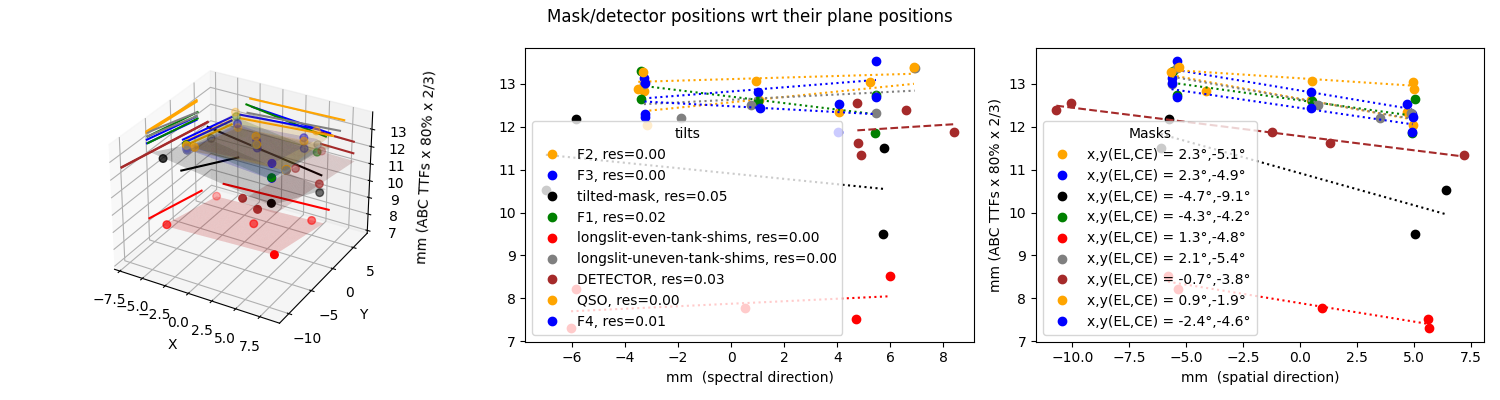

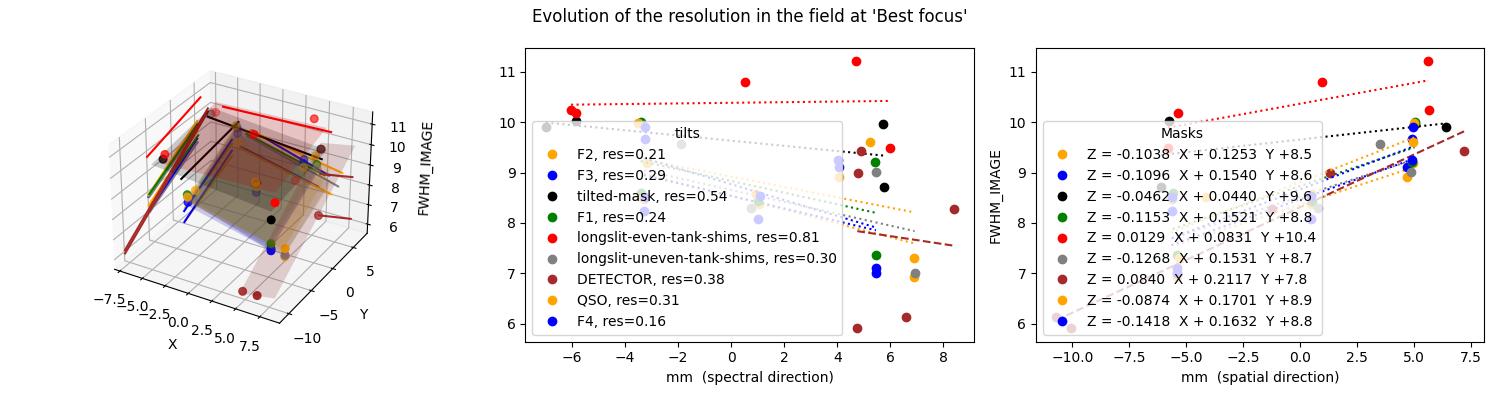

In [167]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[15.2,10.5,9.95]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/*/",lname = lambda a : a.split("/")[-2].split("_")[-1],n=10,f_guider=1,f_detector=1)

# fig, (ax, ax0, ax1) = plot_masks(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[15.2,10.5,9.95],path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/*/")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


folders:  ['/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_19_F2/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_59_F3/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-61_F1/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-141_longslit-even-tank-shims/', '/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/con

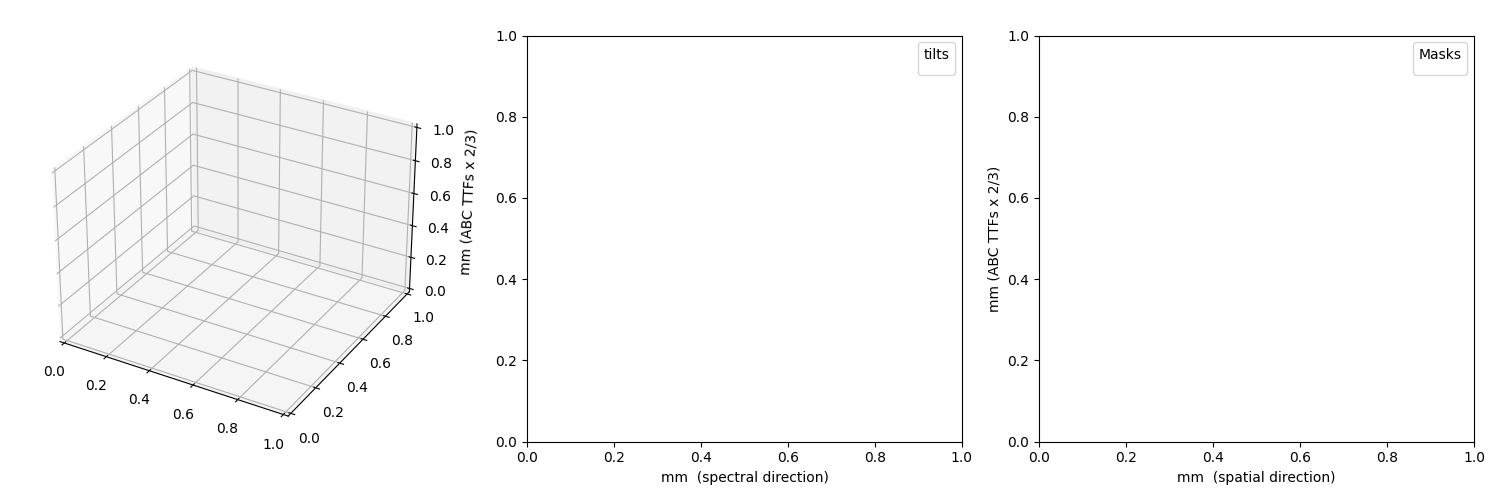

In [18]:
fig, (ax, ax0, ax1) = plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/*/",n=10,factor=0.8*2/3)
# fig, (ax, ax0, ax1) = plot_masks(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks_April&May/ROTENC_-*long*/",title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)#, z_direction="FWHM_IMAGE")


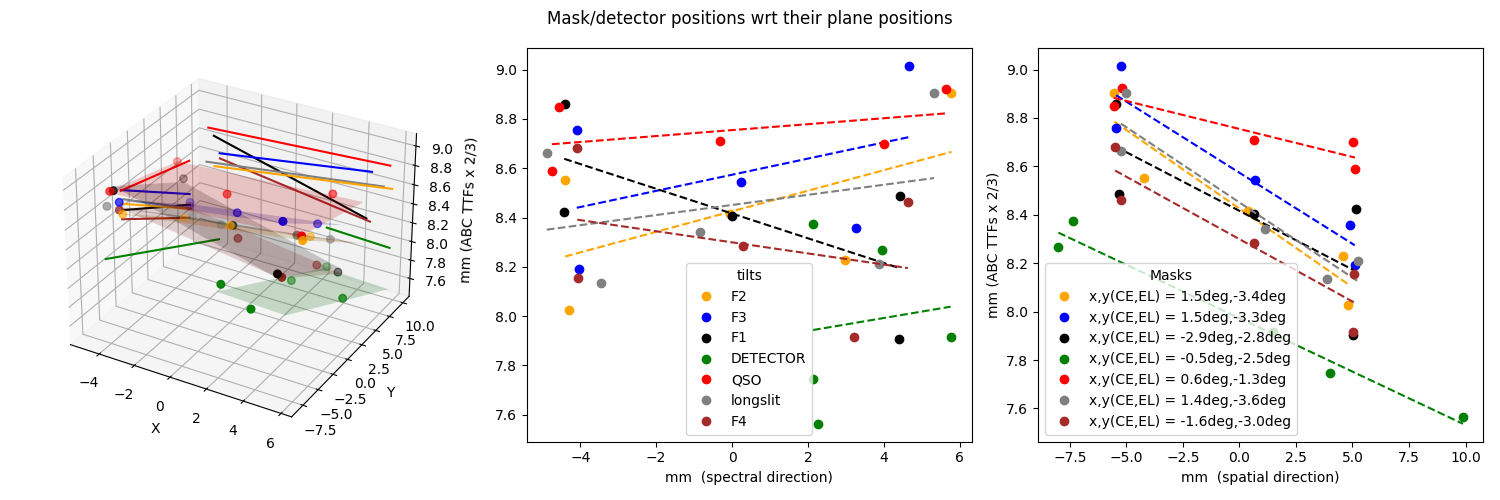

In [30]:
fig, (ax, ax0, ax1) = plot_masks(title="Mask/detector positions wrt their plane positions",n=10,factor=0.8*2/3)



-45deg 12.5 8.5 5.5
45deg 8.7 12 3.7
0deg 13.45 9.75 3.45


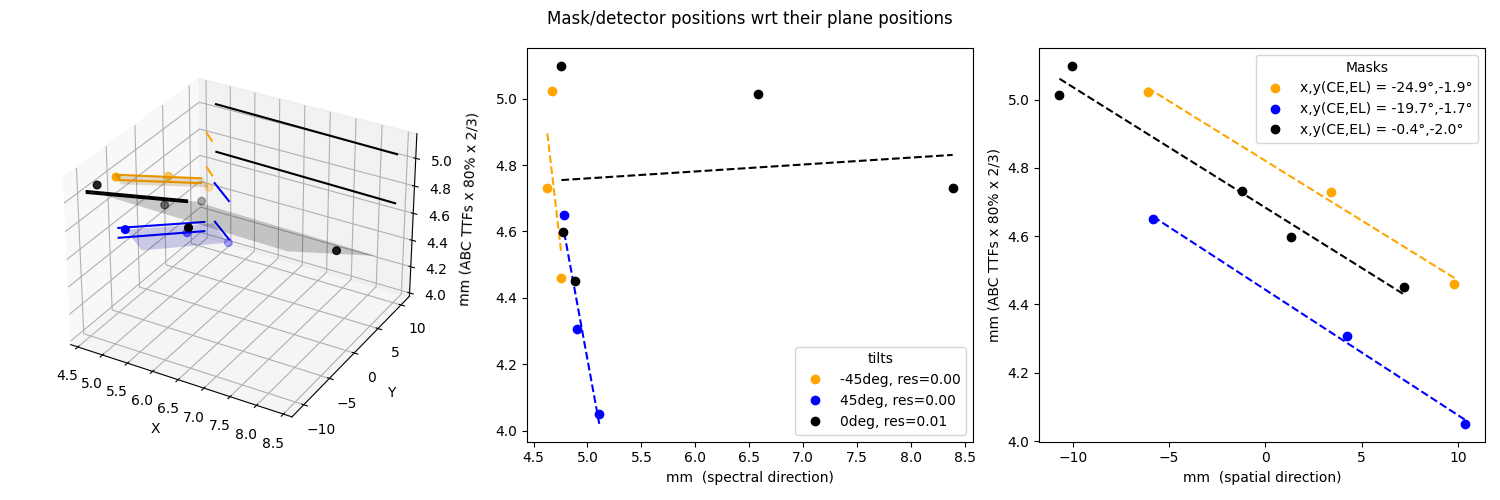

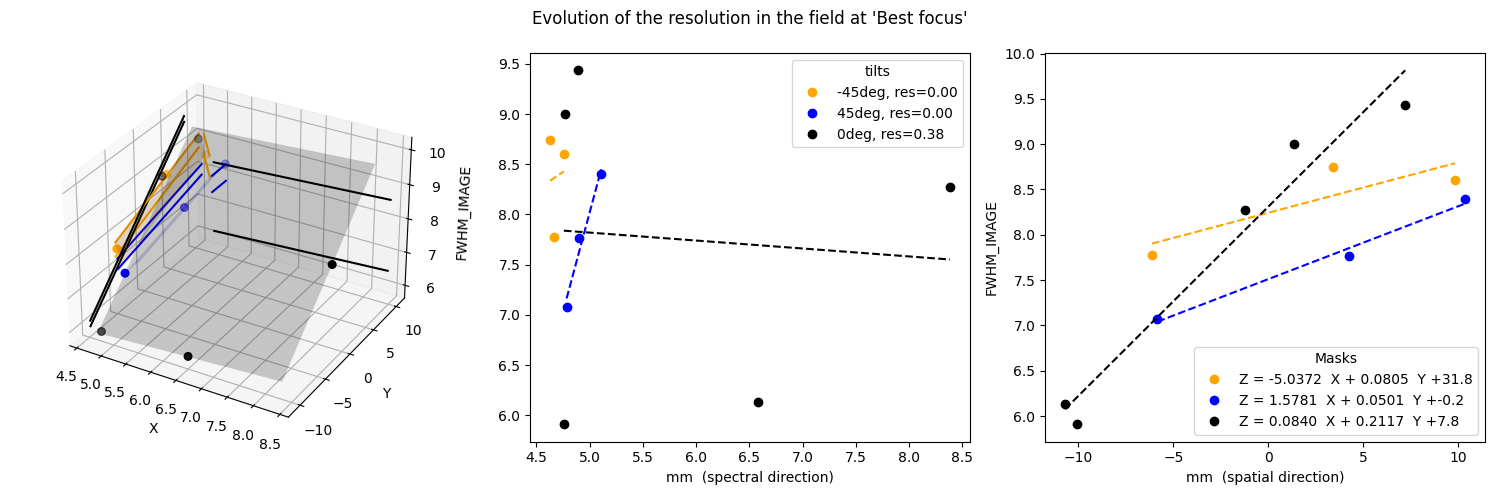

In [110]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230525/thrufocus2/ROT/*/*", ABCs=[[12.5, 8.5, 5.5],[8.7, 12, 3.7],[13.45, 9.75, 3.45]])

In [84]:
    # for folder,c in zip(glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/GOBC_data/confocality_masks/DETECTOR/")[:],["orange","b","k","g","r","orange"]):
    # folder = "/Users/Vincent/DS9QuickLookPlugIn/subsets/confocality_masks/DETECTOR"
        # for f in glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230425/through_focus/?/*_cat.fits"):
        # for f in glob.glob("/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230525/dets/*_cat.fits"):
        # paths=glob.glob("/Users/Vincent/DS9QuickLookPlugIn/subsets/230413_16H00m22/ROTENC_-20.99998/**/**/Th*.csv")
        # stack_images_path(paths, Type="nanmean", clipping=3, dtype=float, fname="", std=False, name=None)    
            # print(f)
            # a = Table.read(os.path.dirname(paths[0])+"/stack_cat.csv")


Throughfocus_130_140_cat_202.fits 12.7 18 5
Throughfocus_144_154_cat_202.fits 12.7 18 5
Throughfocus_157_167_cat_202.fits 12.7 18 5
Throughfocus_170_180_cat_202.fits 12.7 18 5
Throughfocus_182_192_cat_202.fits 12.7 18 5
Throughfocus_195_205_cat_202.fits 12.7 18 5
Throughfocus_209_219_cat_202.fits 12.7 18 5
Throughfocus_209_219_cat_206.fits 12.7 18 5
Throughfocus_182_192_cat_206.fits 12.7 18 5
Throughfocus_195_205_cat_206.fits 12.7 18 5
Throughfocus_157_167_cat_206.fits 12.7 18 5
Throughfocus_170_180_cat_206.fits 12.7 18 5
Throughfocus_130_140_cat_206.fits 12.7 18 5
Throughfocus_144_154_cat_206.fits 12.7 18 5
Throughfocus_110_120_cat.fits 11.7 17 4
Throughfocus_97_107_cat.fits 11.7 17 4
Throughfocus_39_49_cat.fits 11.7 16 3
Throughfocus_27_37_cat.fits 11.7 16 3
Throughfocus_14_24_cat.fits 11.7 16 3


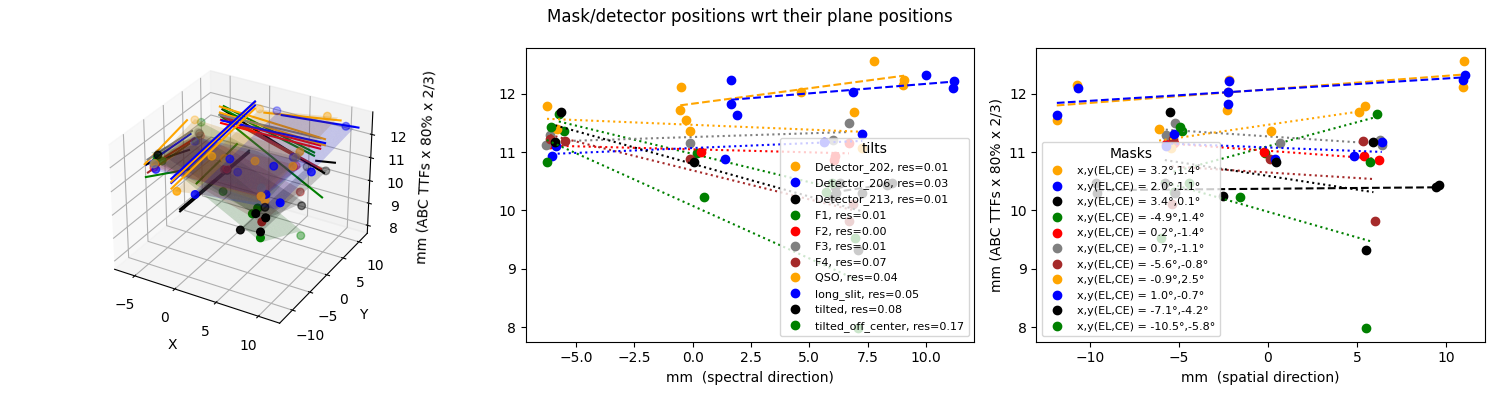

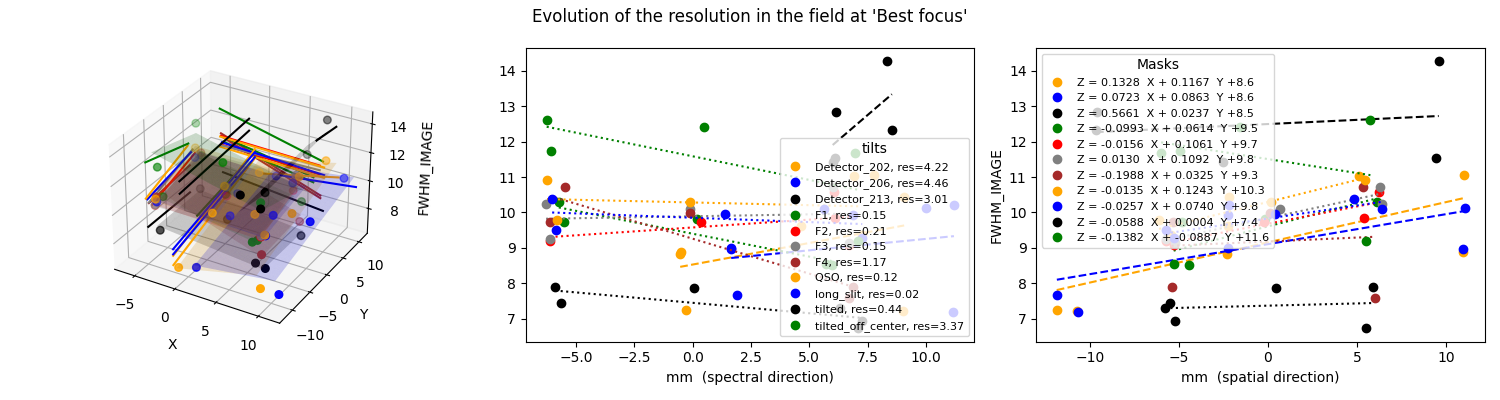

In [175]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[12.7, 18, 5],[12.7, 18, 5],[11.7, 17, 4]],path="/Volumes/VINCENT/GOBC/tilt_June8/*",lname=lambda a :os.path.basename(a),n=10 , f_guider=1,f_detector=1)




# fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[15.2,10.5,9.95]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230609/*")


202 12.7 18 5
202 12.7 18 5
202 12.7 18 5
202 12.7 18 5
202 12.7 18 5
202 12.7 18 5
202 12.7 18 5
206 12.7 18 5
206 12.7 18 5
206 12.7 18 5
206 12.7 18 5
206 12.7 18 5
206 12.7 18 5
206 12.7 18 5
213 11.7 17 4
213 11.7 17 4
213 11.7 16 3
213 11.7 16 3
213 11.7 16 3
Before 15.2 10.5 9.95
Before 15.2 10.5 9.95
Before 15.2 10.5 9.95
Before 15.2 10.5 9.95
Before 15.2 10.5 9.95


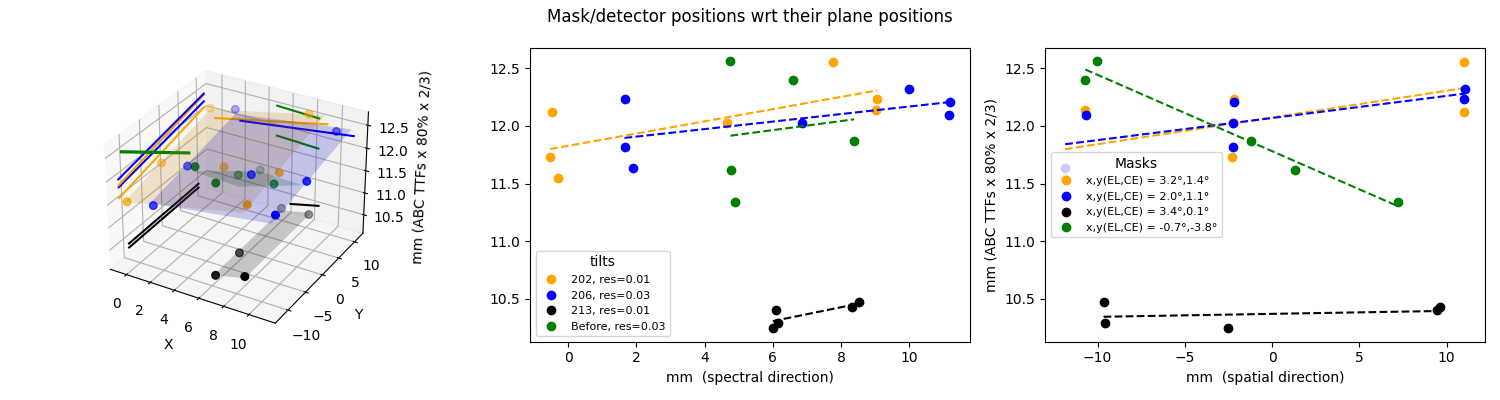

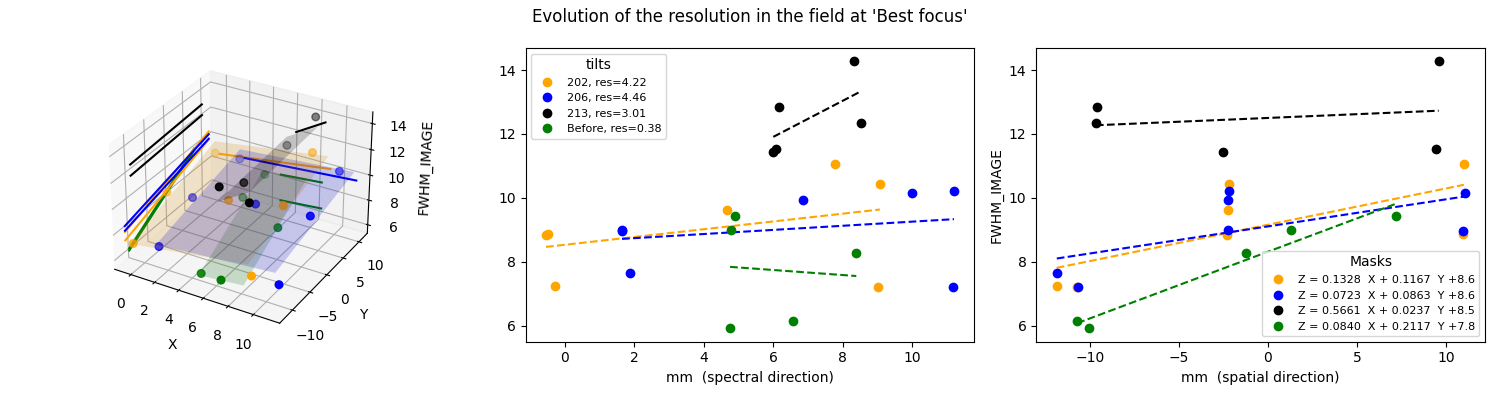

In [178]:
# fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[15.2,10.5,9.95]]*10,path="/Volumes/VINCENT/GOBC/tilt_June8/De*",lname=lambda a :os.path.basename(a) )
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[12.7, 18, 5],[12.7, 18, 5],[11.7, 17, 4],[15.2,	10.5,	9.95]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230609/uv_tilt/*/",lname=lambda a :os.path.basename(os.path.dirname(a)),n=10 , f_guider=1,f_detector=1)
# fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[12.7, 18, 5],[11.7, 17, 4],[12.7, 18, 5]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230609/uv_tilt/???/",lname=lambda a :os.path.basename(a),n=1 )


Throughfocus_143_153_cat_202.fits 14.5 9 14.5
Throughfocus_159_169_cat_202.fits 14.5 9 14.5
Throughfocus_171_181_cat_202.fits 14.5 9 14.5
Throughfocus_186_196_cat_202.fits 14.5 9 14.5
Throughfocus_199_209_cat_202.fits 14.5 9 14.5
Throughfocus_143_153_cat_206.fits 14.5 9 14.5
Throughfocus_159_169_cat_206.fits 14.5 9 14.5
Throughfocus_171_181_cat_206.fits 14.5 9 14.5
Throughfocus_186_196_cat_206.fits 14.5 9 14.5
Throughfocus_199_209_cat_206.fits 14.5 9 14.5
Throughfocus_73_83_cat_213.fits 14.5 9 14.5
Throughfocus_89_99_cat_213.fits 14.5 9 14.5
Throughfocus_101_111_cat_213.fits 14.5 9 14.5
Throughfocus_113_123_cat_213.fits 14.5 9 14.5


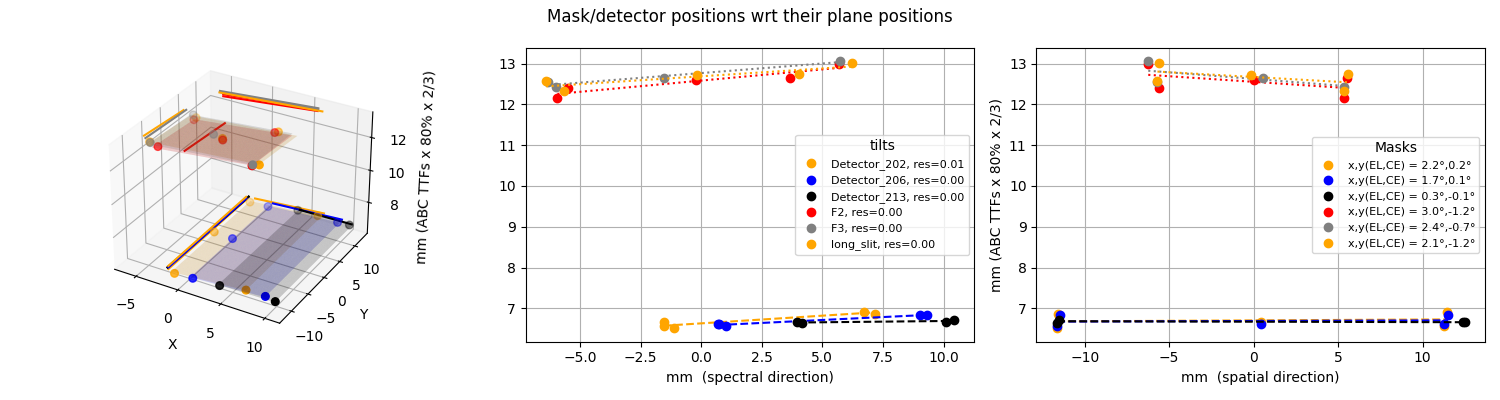

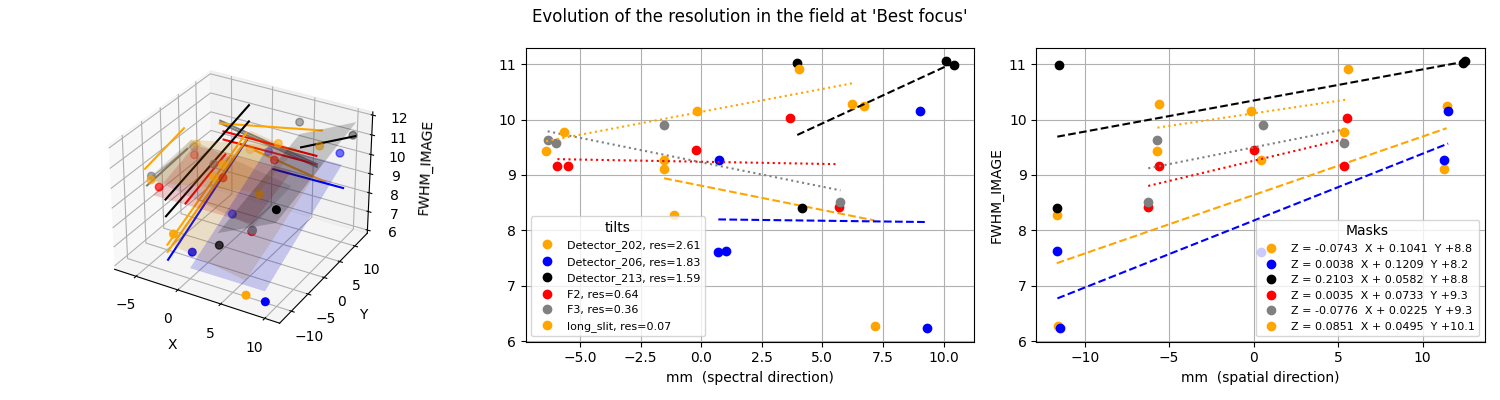

In [206]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[14.5, 9, 14.5]]*10,path="/Volumes/VINCENT/GOBC/220612/[FDl]*",lname=lambda a :os.path.basename(a),n=10)# , f_guider=1,f_detector=1)





Throughfocus_143_153_cat_202.fits 14.5 9 14.5
Throughfocus_159_169_cat_202.fits 14.5 9 14.5
Throughfocus_171_181_cat_202.fits 14.5 9 14.5
Throughfocus_186_196_cat_202.fits 14.5 9 14.5
Throughfocus_199_209_cat_202.fits 14.5 9 14.5
Throughfocus_143_153_cat_206.fits 14.5 9 14.5
Throughfocus_159_169_cat_206.fits 14.5 9 14.5
Throughfocus_171_181_cat_206.fits 14.5 9 14.5
Throughfocus_186_196_cat_206.fits 14.5 9 14.5
Throughfocus_199_209_cat_206.fits 14.5 9 14.5
Throughfocus_73_83_cat_213.fits 14.5 9 14.5
Throughfocus_89_99_cat_213.fits 14.5 9 14.5
Throughfocus_101_111_cat_213.fits 14.5 9 14.5
Throughfocus_113_123_cat_213.fits 14.5 9 14.5


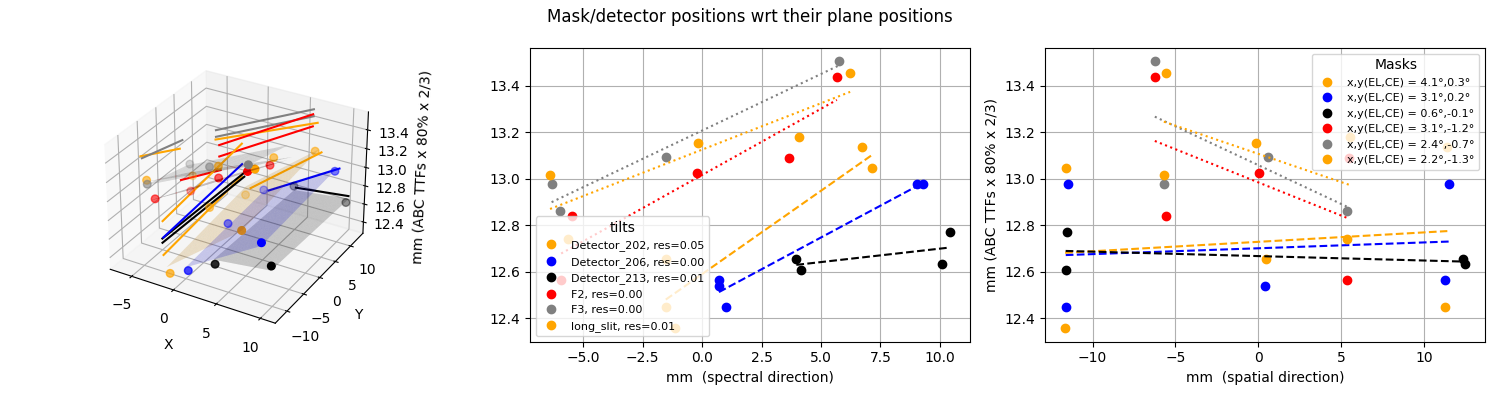

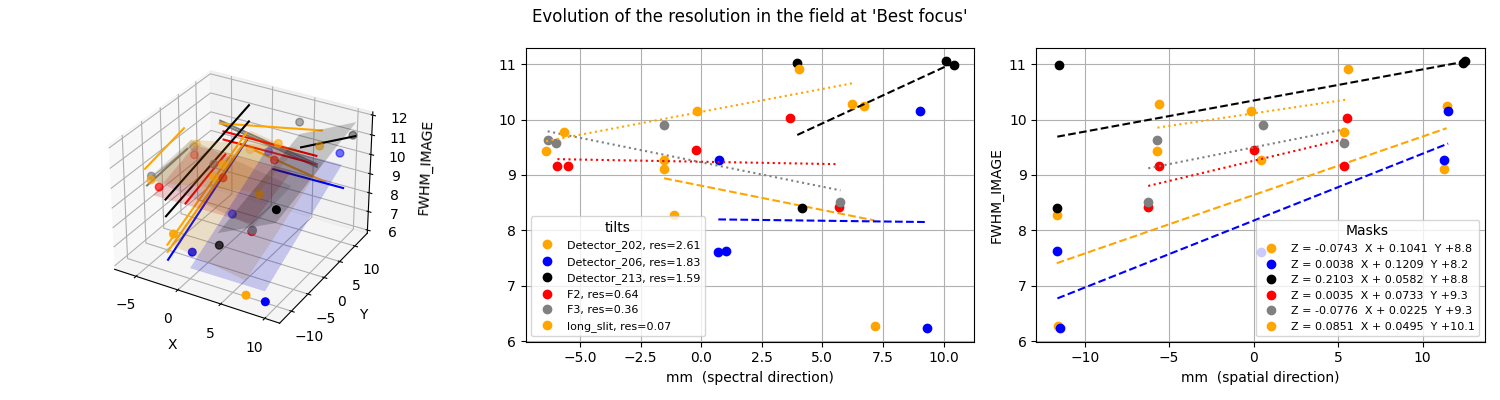

In [207]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[14.5, 9, 14.5]]*10,path="/Volumes/VINCENT/GOBC/220612/[FDl]*",lname=lambda a :os.path.basename(a),n=10 , f_guider=1,f_detector=1)


Throughfocus_68_78_cat_206.fits 17.4 8.9 10.45
Throughfocus_37_47_cat_206.fits 17.4 8.9 10.45
Throughfocus_51_61_cat_206.fits 17.4 8.9 10.45
Throughfocus_81_91_cat_206.fits 17.4 8.9 10.45
Throughfocus_117_127_cat_206.fits 17.4 8.9 10.45
Throughfocus_127_137_cat_206.fits 12.9 6.4 10.2
Throughfocus_150_160_cat_206.fits 12.9 6.4 10.2
Throughfocus_138_148_cat_206.fits 12.9 6.4 10.2
Throughfocus_104_114_cat_206.fits 12.9 6.4 10.2
Throughfocus_115_125_cat_206.fits 12.9 6.4 10.2
Throughfocus_70_80_cat_206.fits 13.65 9.15 14.45
Throughfocus_49_59_cat_206.fits 13.65 9.15 14.45
Throughfocus_35_45_cat_206.fits 13.65 9.15 14.45


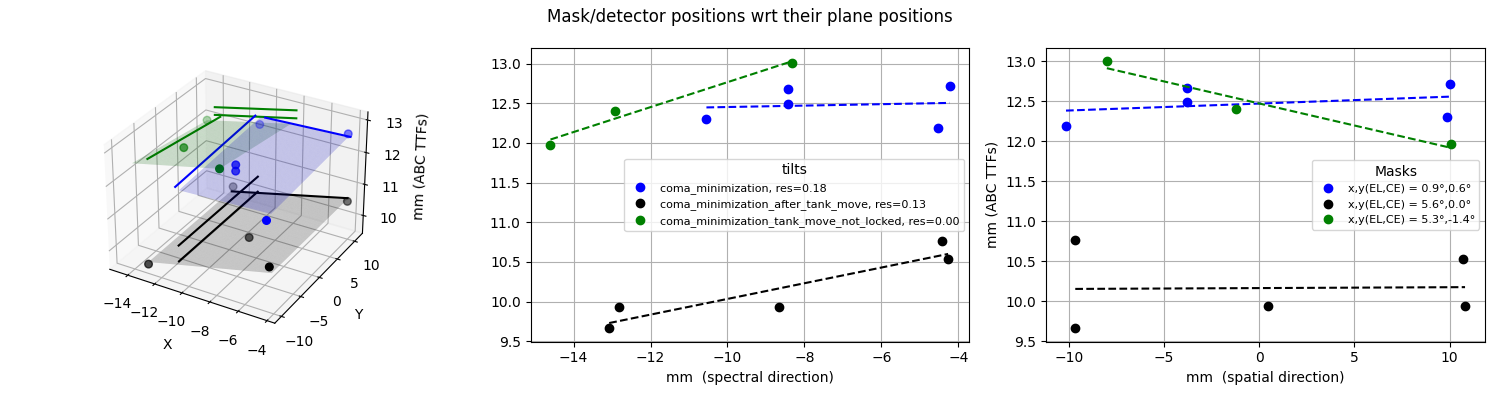

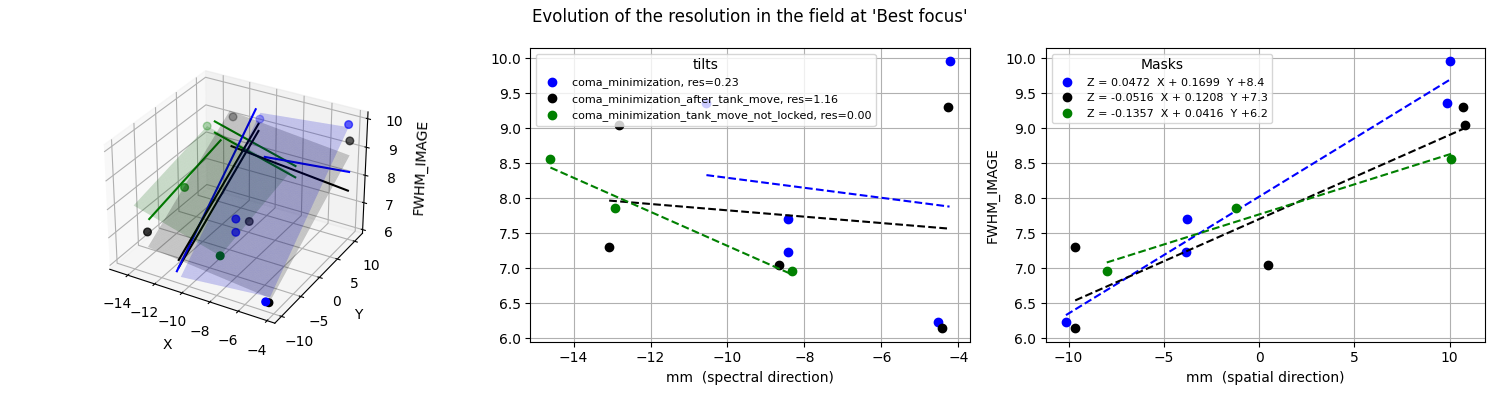

In [16]:
fig, (ax, ax0, ax1) = plot_tilt_and_fwhm(z_direction="FWHM_IMAGE", title="Evolution of the resolution in the field at 'Best focus'",ABCs=[[13.65,	9.15,	14.45],[17.4,	8.9,	10.45],[12.9,	6.4,	10.2]]*10,path="/Users/Vincent/Library/CloudStorage/GoogleDrive-vp2376@columbia.edu/.shortcut-targets-by-id/1ZgB7kY-wf7meXrq8v-1vIzor75aRdLDn/FIREBall-2/FB2_2023/DOBC_data/230616/*",lname=lambda a :os.path.basename(a),n=10 , f_guider=1,f_detector=1)
